<a href="https://colab.research.google.com/github/dikoharyadhanto/basic_feature_discovering_for_ML/blob/main/Basic_Feature_Discovering_for_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/Kaggle'

In [ ]:
!kaggle competitions download -c titanic

train.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)
gender_submission.csv: Skipping, found more recently modified local copy (use --force to force download)


# **Import Libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

import string
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# **Import Data Set dan Concat Data Frame**

In [ ]:
# Membuat Function `concat_df` untuk menggabungkan dataframe
def concat_df(train_data, test_data):
    # Returns a concatenated df of training and test set
    return pd.concat([train_data, test_data], sort=True).reset_index(drop=True)

In [ ]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_all = concat_df(df_train, df_test)

In [ ]:
df_train.name = 'Training Set'
df_test.name = 'Test Set'
df_all.name = 'All Set'

dfs = [df_train, df_test]

# **Explanation of the Dataset**

- **`PassengerId`** is the id of the row, so it has no effect on the target being searched for
- **`Survived`** is the target to be predicted, value `0` = Not Survived and value `1` = Survived
- Pclass (Passenger Class) is a category of socioeconomic level of passengers with a value (`1`, `2` or `3`):
`1` = Upper Class
`2` = Middle Class
`3` = Lower Class
- **`Name`**, **`Sex`** and **`Age`** are self-explanatory data
- **`SibSp`** is the number of relatives of passengers
- **`Parch`** is the number of Parents and children of passengers
- **`Ticket`** is the number of passenger tickets
- **`Fare`** is the rate charged to passengers
- **`Cabin`** is the passenger cabin number
- **`Embarked`** is the port of departure there are 3 ports (C, Q or S):
C = Cherbourg
Q = Queenstown
S = Southampton

# **Data Profiling**

In [ ]:
print('Number of Training Examples = {}'.format(df_train.shape[0]))
print('Number of Test Examples = {}\n'.format(df_test.shape[0]))
print('Training X Shape = {}'.format(df_train.shape))
print('Training y Shape = {}\n'.format(df_train['Survived'].shape[0]))
print('Test X Shape = {}'.format(df_test.shape))
print('Test y Shape = {}\n'.format(df_test.shape[0]))
print(df_train.columns)
print(df_test.columns)

Number of Training Examples = 891
Number of Test Examples = 418

Training X Shape = (891, 12)
Training y Shape = 891

Test X Shape = (418, 11)
Test y Shape = 418

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


In [ ]:
df_train.info(memory_usage=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)

In [ ]:
df_test.info(memory_usage=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)

In [ ]:
df_train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [ ]:
df_test.head(10)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,NaN,S


## **Checking Missing Values**

In [ ]:
df_train.name = 'Training Set'
df_test.name = 'Test Set'
df_all.name = 'All Set' 

dfs = [df_train, df_test]

def display_missing(df):    
    for col in df.columns.tolist():          
        print('{} column missing values: {}'.format(col, df[col].isnull().sum()))
    print('\n')

for df in dfs:
    print('{}'.format(df.name))
    display_missing(df)

Training Set
PassengerId column missing values: 0
Survived column missing values: 0
Pclass column missing values: 0
Name column missing values: 0
Sex column missing values: 0
Age column missing values: 177
SibSp column missing values: 0
Parch column missing values: 0
Ticket column missing values: 0
Fare column missing values: 0
Cabin column missing values: 687
Embarked column missing values: 2


Test Set
PassengerId column missing values: 0
Pclass column missing values: 0
Name column missing values: 0
Sex column missing values: 0
Age column missing values: 86
SibSp column missing values: 0
Parch column missing values: 0
Ticket column missing values: 0
Fare column missing values: 1
Cabin column missing values: 327
Embarked column missing values: 0




## **Filling the missing value**

In [ ]:
age_by_pclass_sex = df_all.groupby(['Sex', 'Pclass']).median()['Age']
age_by_pclass_sex.head()
for pclass in range(1, 4):
    for sex in ['female', 'male']:
        print('Median age of Pclass {} {}s: {}'.format(pclass, sex, age_by_pclass_sex[sex][pclass]))
print('Median age of all passengers: {}'.format(df_all['Age'].median()))

Median age of Pclass 1 females: 36.0
Median age of Pclass 1 males: 42.0
Median age of Pclass 2 females: 28.0
Median age of Pclass 2 males: 29.5
Median age of Pclass 3 females: 22.0
Median age of Pclass 3 males: 25.0
Median age of all passengers: 28.0


In [ ]:
# Filling the missing values in Age with the medians of Sex and Pclass groups
df_all['Age'] = df_all.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))
df_all['Age'].isna().sum()

0

In [ ]:
# Filling the missing values in Embarked with S
df_all['Embarked'] = df_all['Embarked'].fillna('S')

In [ ]:
df_all['Embarked'].isna().sum()

0

In [ ]:
med_fare = df_all.groupby(['Pclass', 'Parch', 'SibSp']).Fare.median()[3][0][0]
# Filling the missing value in Fare with the median Fare of 3rd class alone passenger
df_all['Fare'] = df_all['Fare'].fillna(med_fare)

In [ ]:
df_all['Fare'].isna().sum()

0

In [ ]:
df_all['Cabin'] = df_all['Cabin'].fillna('Unknown')
df_all['Cabin'].isna().sum()

0

In [ ]:
df_all.isna().sum()

Age              0
Cabin            0
Embarked         0
Fare             0
Name             0
Parch            0
PassengerId      0
Pclass           0
Sex              0
SibSp            0
Survived       418
Ticket           0
dtype: int64

# **Exploratory Data Analysis**

## **Correlation Between Variables**

In [ ]:
df_train_corr = df_train.corr().abs()
print(df_train_corr.to_string())

             PassengerId  Survived    Pclass       Age     SibSp     Parch      Fare
PassengerId     1.000000  0.005007  0.035144  0.036847  0.057527  0.001652  0.012658
Survived        0.005007  1.000000  0.338481  0.077221  0.035322  0.081629  0.257307
Pclass          0.035144  0.338481  1.000000  0.369226  0.083081  0.018443  0.549500
Age             0.036847  0.077221  0.369226  1.000000  0.308247  0.189119  0.096067
SibSp           0.057527  0.035322  0.083081  0.308247  1.000000  0.414838  0.159651
Parch           0.001652  0.081629  0.018443  0.189119  0.414838  1.000000  0.216225
Fare            0.012658  0.257307  0.549500  0.096067  0.159651  0.216225  1.000000


If you look at this table you will know the correlation between the columns. Correlation can be determined by approaching the value of `1` for positive correlation and `-1` for inverse correlation.

In this data, it can be seen that our target variable Survived has a very large correlation with `Pclass` and `Fare`. While `Age` is closely related to `Pclass`, Sibling Spouse (`SibSp`), Parent Children (`Parch`).

It can be assumed that most of the survivors are people with a `PClass` above and a person's age can be said to be bringing a sibling/parent/child/spouse.

And the fare (`price`) is of course related to the `Pclass` (passenger class) of a passenger.

If you look at this table you will know the correlation between the columns. Correlation can be determined by approaching the value of 1 for positive correlation and -1 for inverse correlation.

In this data, it can be seen that our target variable Survived has a very large correlation with Pclass and Fare. While Age is closely related to Pclass, Sibling Spouse (SibSp), Parent Children (Parch).

It can be assumed that most of the survivors are people with a PClass above and a person's age can be said to be bringing a sibling/parent/child/spouse.

And the fare (price) is of course related to the Pclass (passenger class) of a passenger.

# **Data Visualization**

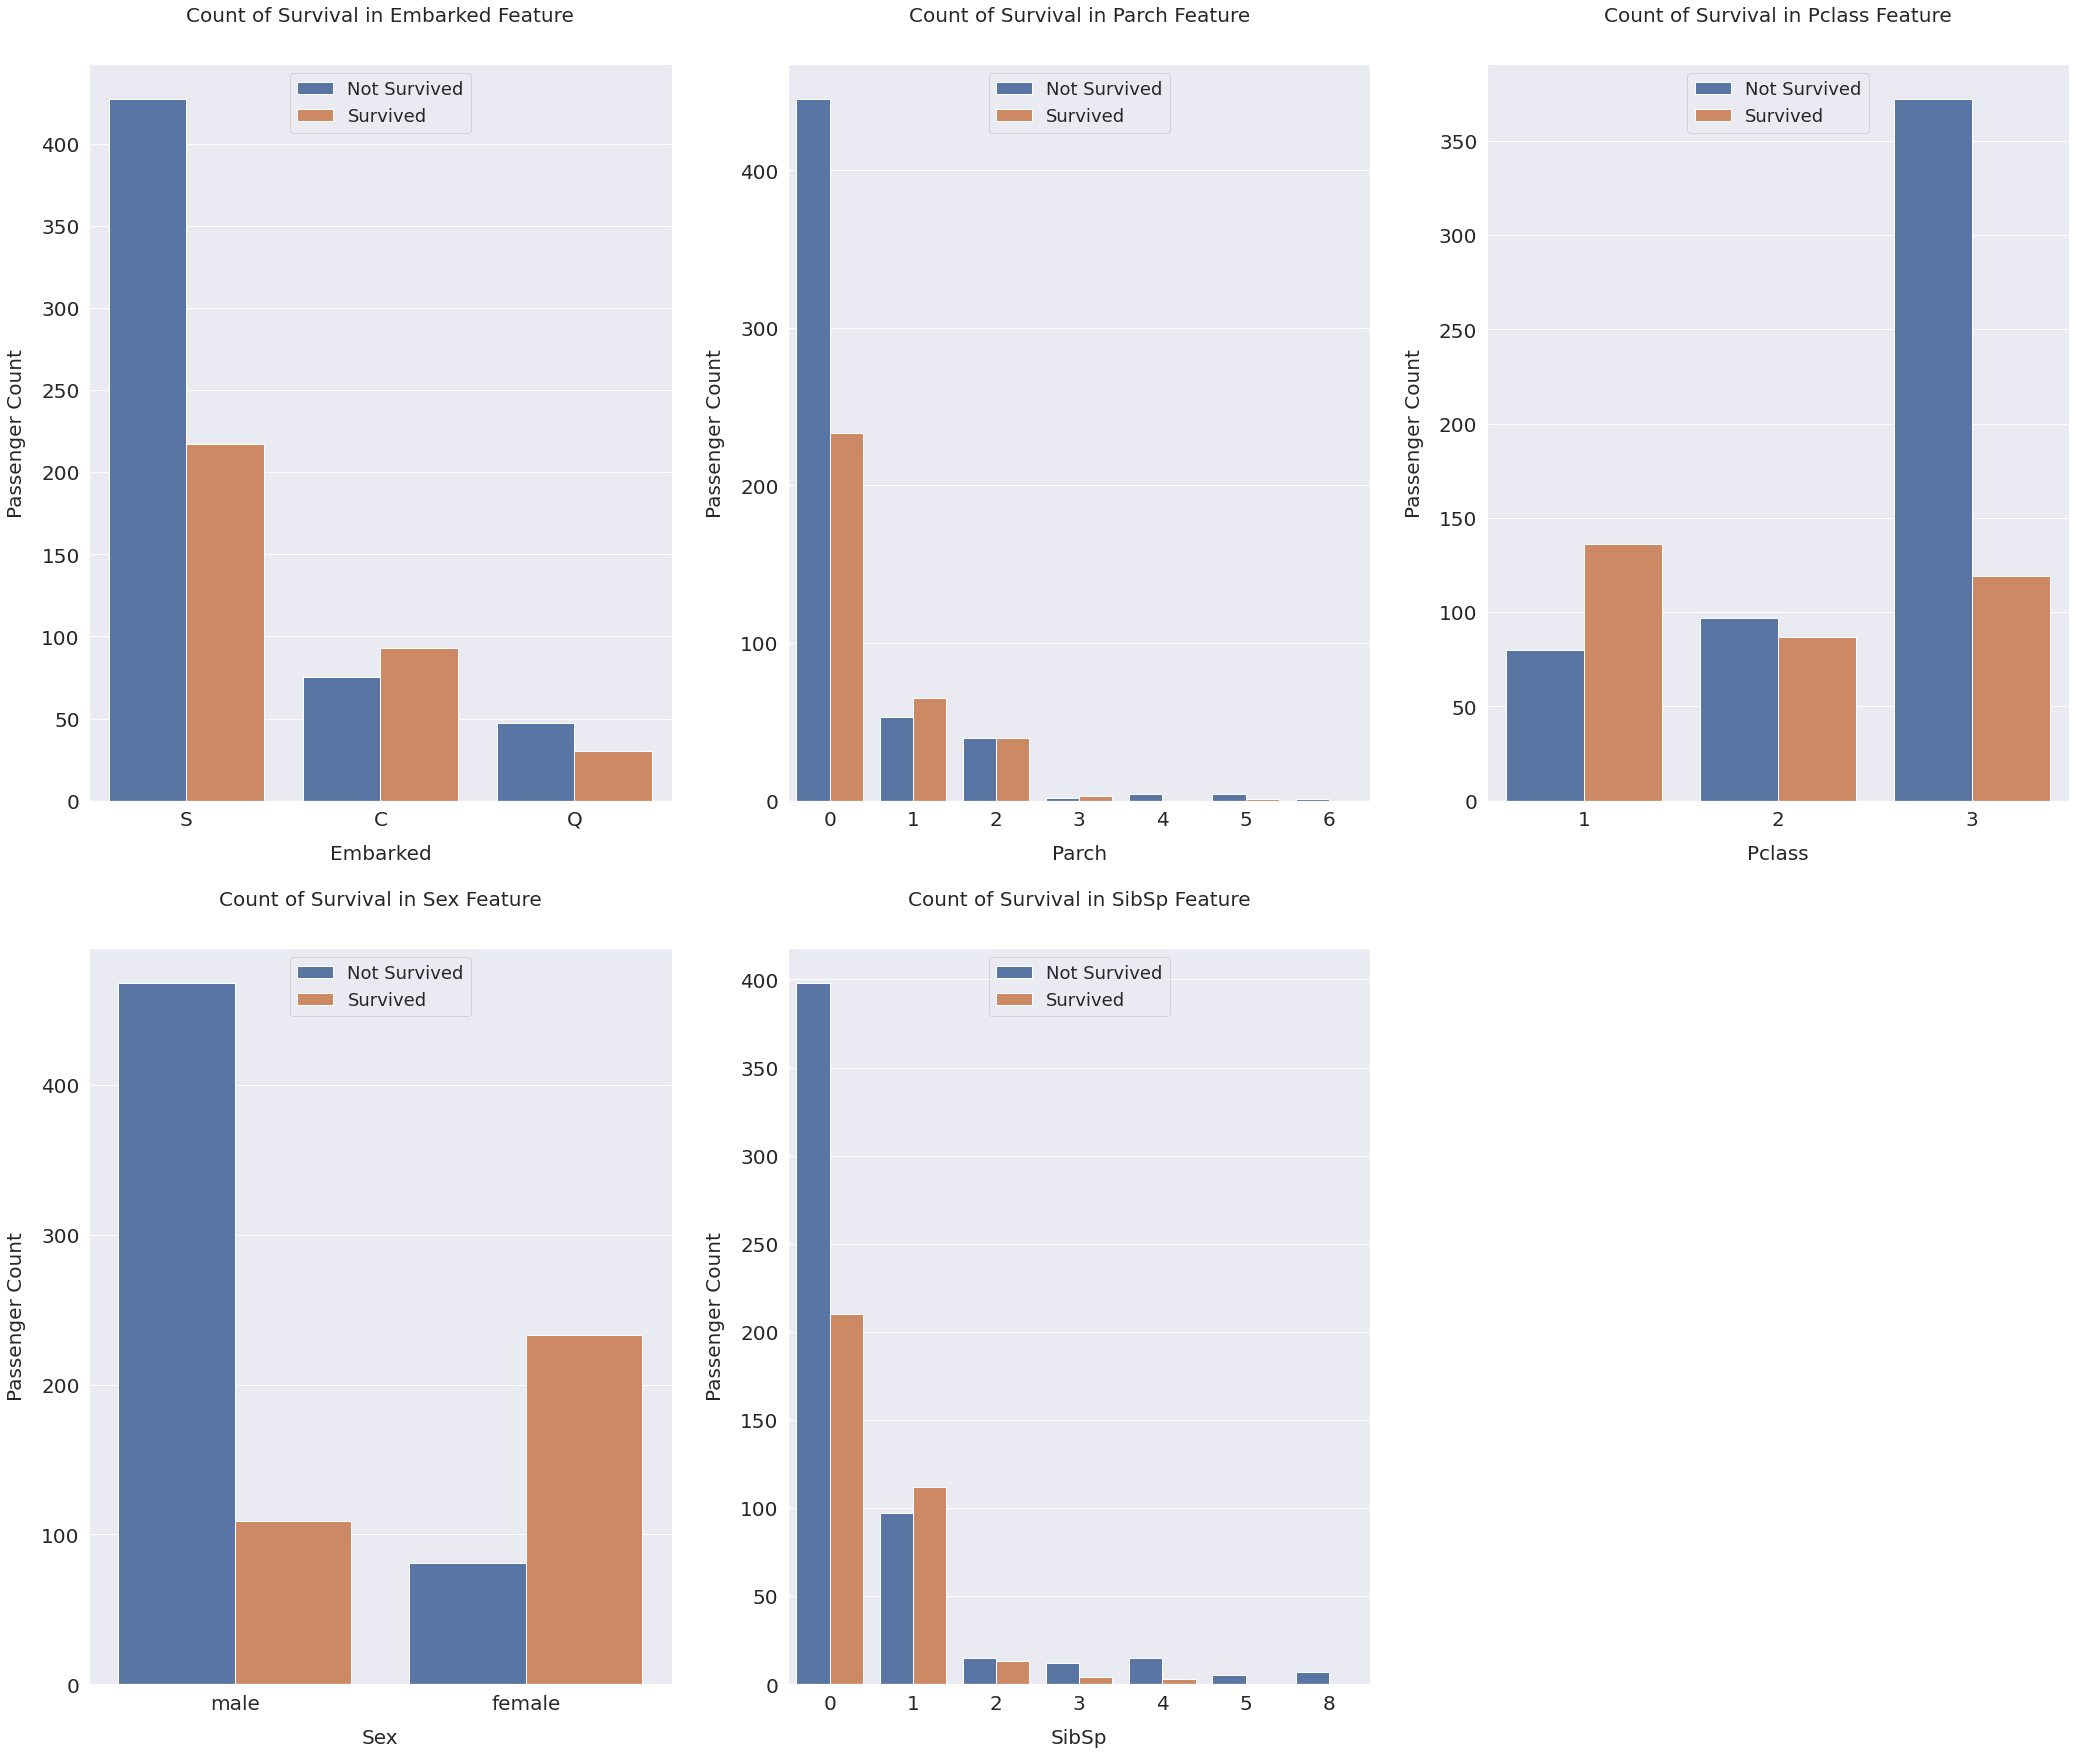

In [ ]:
import matplotlib.pyplot as plt

cat_features = ['Embarked', 'Parch', 'Pclass', 'Sex', 'SibSp']

fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(20, 20))
plt.subplots_adjust(right=1.5, top=1.25)

for i, feature in enumerate(cat_features, 1):    
    plt.subplot(2, 3, i)
    sns.countplot(x=feature, hue='Survived', data=df_train)
    
    plt.xlabel('{}'.format(feature), size=20, labelpad=15)
    plt.ylabel('Passenger Count', size=20, labelpad=15)    
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=20)
    
    plt.legend(['Not Survived', 'Survived'], loc='upper center', prop={'size': 18})
    plt.title('Count of Survival in {} Feature'.format(feature), size=20, y=1.05)

plt.show()

In [ ]:
df_all['Fare'].head()

0     7.2500
1    71.2833
2     7.9250
3    53.1000
4     8.0500
Name: Fare, dtype: float64

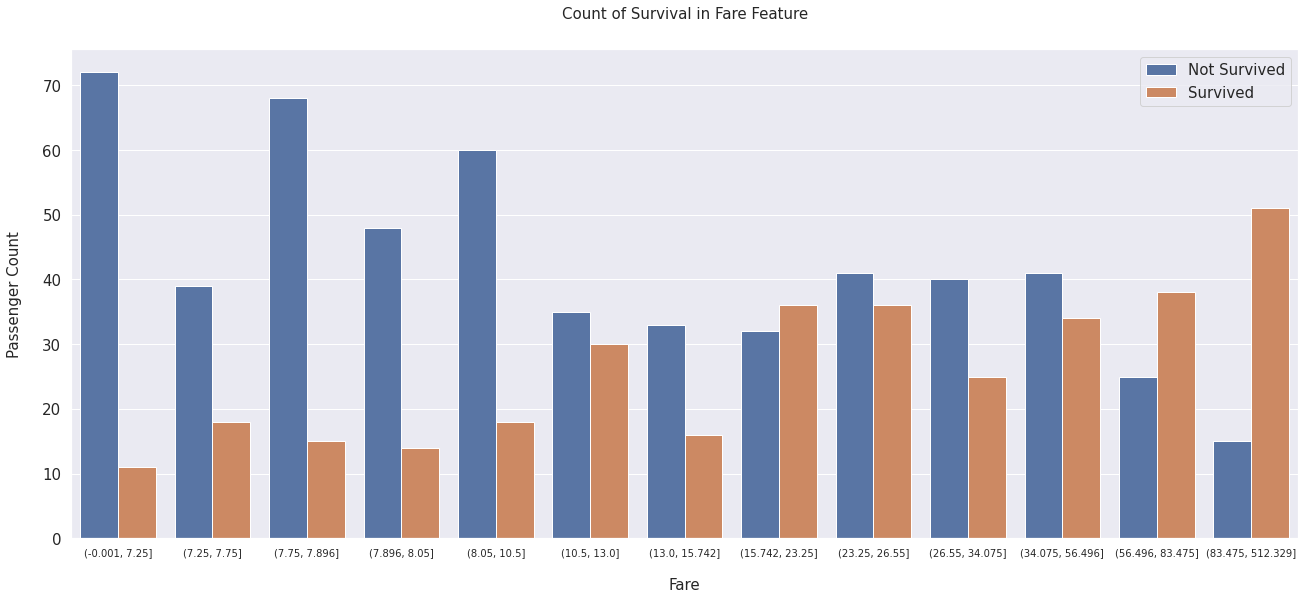

In [ ]:
import matplotlib.pyplot as plt

df_all['Fare'] = pd.qcut(df_all['Fare'], 13)

fig, axs = plt.subplots(figsize=(22, 9))
sns.countplot(x='Fare', hue='Survived', data=df_all)

plt.xlabel('Fare', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Count of Survival in {} Feature'.format('Fare'), size=15, y=1.05)

plt.show()

In [ ]:
df_all['Age'].head()

0    22.0
1    38.0
2    26.0
3    35.0
4    35.0
Name: Age, dtype: float64

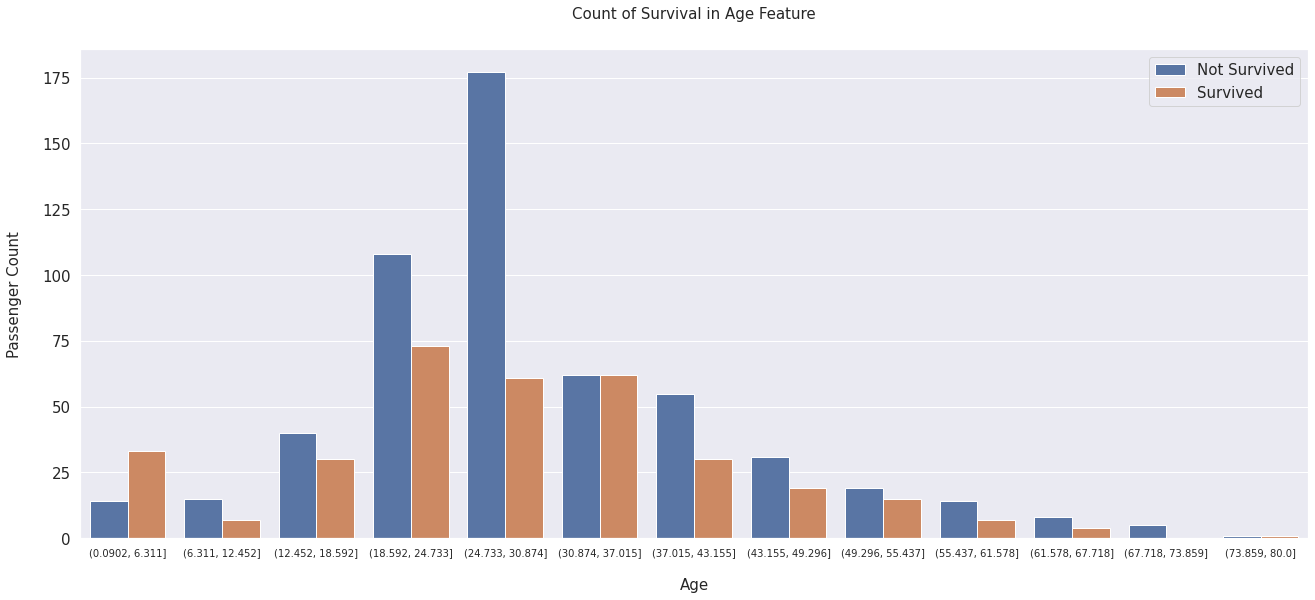

In [ ]:
import matplotlib.pyplot as plt

df_all['Age'] = pd.cut(df_all['Age'], 13)

fig, axs = plt.subplots(figsize=(22, 9))
sns.countplot(x='Age', hue='Survived', data=df_all)

plt.xlabel('Age', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Count of Survival in {} Feature'.format('Age'), size=15, y=1.05)

plt.show()

## **Feature Engineering**

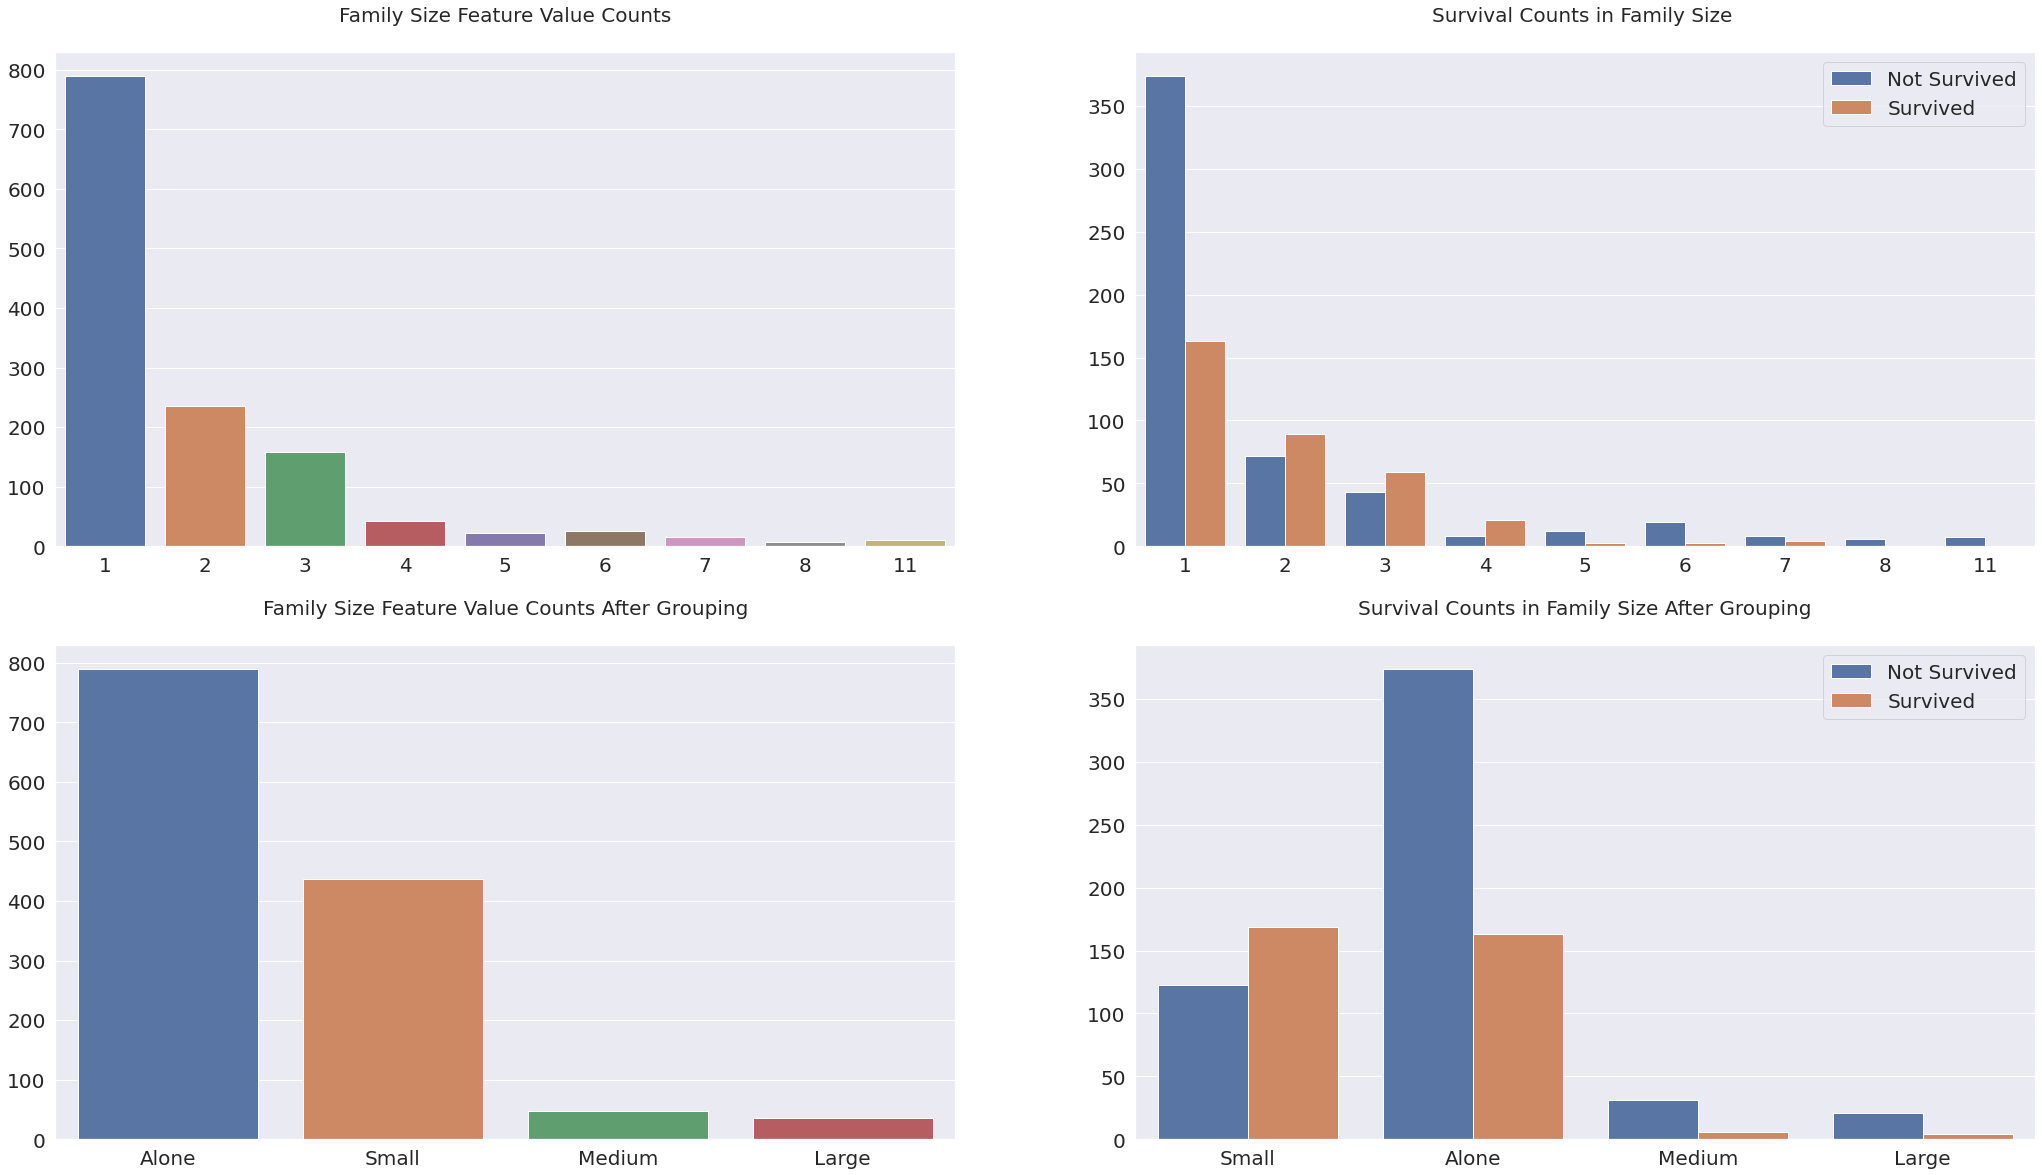

In [ ]:
import matplotlib.pyplot as plt
df_all['Family_Size'] = df_all['SibSp'] + df_all['Parch'] + 1

fig, axs = plt.subplots(figsize=(20, 20), ncols=2, nrows=2)
plt.subplots_adjust(right=1.5)

sns.barplot(x=df_all['Family_Size'].value_counts().index, y=df_all['Family_Size'].value_counts().values, ax=axs[0][0])
sns.countplot(x='Family_Size', hue='Survived', data=df_all, ax=axs[0][1])

axs[0][0].set_title('Family Size Feature Value Counts', size=20, y=1.05)
axs[0][1].set_title('Survival Counts in Family Size ', size=20, y=1.05)

family_map = {1: 'Alone', 2: 'Small', 3: 'Small', 4: 'Small', 5: 'Medium', 6: 'Medium', 7: 'Large', 8: 'Large', 11: 'Large'}
df_all['Family_Size_Grouped'] = df_all['Family_Size'].map(family_map)

sns.barplot(x=df_all['Family_Size_Grouped'].value_counts().index, y=df_all['Family_Size_Grouped'].value_counts().values, ax=axs[1][0])
sns.countplot(x='Family_Size_Grouped', hue='Survived', data=df_all, ax=axs[1][1])

axs[1][0].set_title('Family Size Feature Value Counts After Grouping', size=20, y=1.05)
axs[1][1].set_title('Survival Counts in Family Size After Grouping', size=20, y=1.05)

for i in range(2):
    axs[i][1].legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 20})
    for j in range(2):
        axs[i][j].tick_params(axis='x', labelsize=20)
        axs[i][j].tick_params(axis='y', labelsize=20)
        axs[i][j].set_xlabel('')
        axs[i][j].set_ylabel('')

plt.show()

Kategorinya adalah seperti berikut.

1. Family Size 1 = Alone
2. Family Size 2, 3 dan 4 = Small
3. Family Size 5 dan 6 = Medium
4. Family Size 7, 8 dan 11 = Large

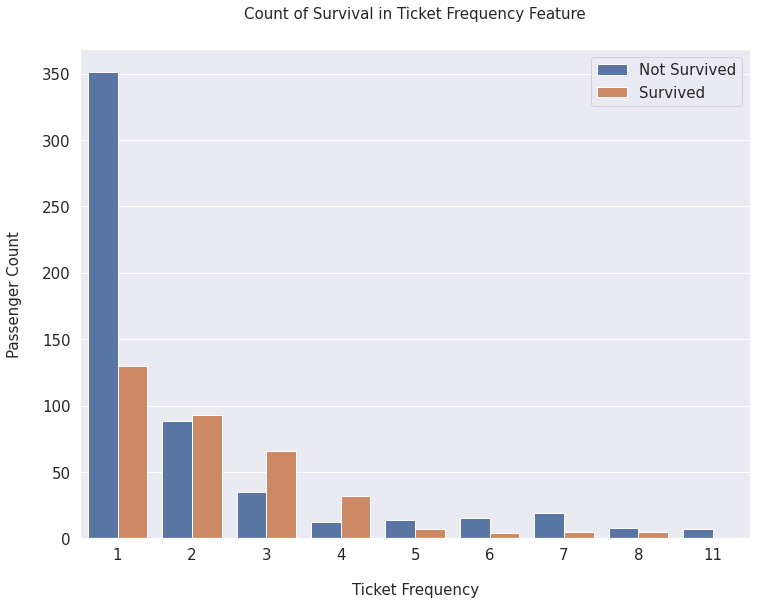

In [ ]:
import matplotlib.pyplot as plt
df_all['Ticket_Frequency'] = df_all.groupby('Ticket')['Ticket'].transform('count')

fig, axs = plt.subplots(figsize=(12, 9))
sns.countplot(x='Ticket_Frequency', hue='Survived', data=df_all)

plt.xlabel('Ticket Frequency', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Count of Survival in {} Feature'.format('Ticket Frequency'), size=15, y=1.05)

plt.show()

In [ ]:
df_all.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Family_Size,Family_Size_Grouped,Ticket_Frequency
0,"(18.592, 24.733]",Unknown,S,"(-0.001, 7.25]","Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,2,Small,1
1,"(37.015, 43.155]",C85,C,"(56.496, 83.475]","Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,2,Small,2
2,"(24.733, 30.874]",Unknown,S,"(7.896, 8.05]","Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,1,Alone,1
3,"(30.874, 37.015]",C123,S,"(34.075, 56.496]","Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,2,Small,2
4,"(30.874, 37.015]",Unknown,S,"(7.896, 8.05]","Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,1,Alone,1


In [ ]:
df_all['Title'] = df_all['Name'].str.split(', ', n = 1, expand = True)[1].str.split('.', n = 1, expand = True)[0]

print(df_all['Title'].unique())

df_all['Is_Married'] = 0
df_all['Is_Married'].loc[df_all['Title'] == 'Mrs'] = 1

print(df_all['Title'].unique())

['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Mme' 'Ms' 'Major' 'Lady'
 'Sir' 'Mlle' 'Col' 'Capt' 'the Countess' 'Jonkheer' 'Dona']
['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Mme' 'Ms' 'Major' 'Lady'
 'Sir' 'Mlle' 'Col' 'Capt' 'the Countess' 'Jonkheer' 'Dona']


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


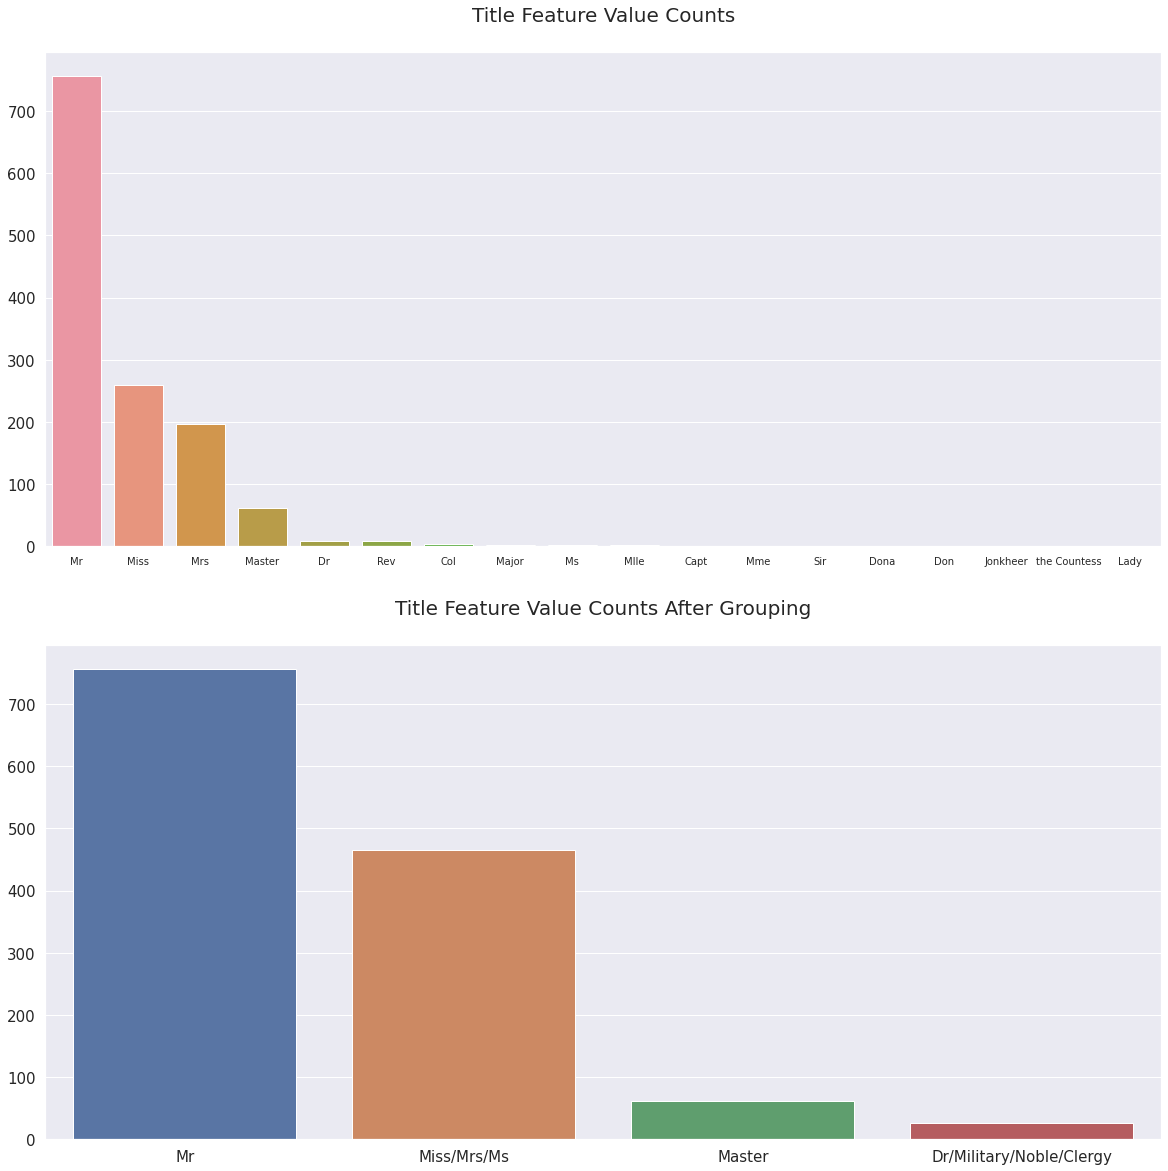

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=2, figsize=(20, 20))
sns.barplot(x=df_all['Title'].value_counts().index, y=df_all['Title'].value_counts().values, ax=axs[0])

axs[0].tick_params(axis='x', labelsize=10)
axs[1].tick_params(axis='x', labelsize=15)

for i in range(2):    
    axs[i].tick_params(axis='y', labelsize=15)

axs[0].set_title('Title Feature Value Counts', size=20, y=1.05)

df_all['Title'] = df_all['Title'].replace(['Miss', 'Mrs','Ms', 'Mlle', 'Lady', 'Mme', 'the Countess', 'Dona'], 'Miss/Mrs/Ms')
df_all['Title'] = df_all['Title'].replace(['Dr', 'Col', 'Major', 'Jonkheer', 'Capt', 'Sir', 'Don', 'Rev'], 'Dr/Military/Noble/Clergy')

sns.barplot(x=df_all['Title'].value_counts().index, y=df_all['Title'].value_counts().values, ax=axs[1])
axs[1].set_title('Title Feature Value Counts After Grouping', size=20, y=1.05)

plt.show()

In [ ]:
df_all.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Family_Size,Family_Size_Grouped,Ticket_Frequency,Title,Is_Married
0,"(18.592, 24.733]",Unknown,S,"(-0.001, 7.25]","Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,2,Small,1,Mr,0
1,"(37.015, 43.155]",C85,C,"(56.496, 83.475]","Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,2,Small,2,Miss/Mrs/Ms,1
2,"(24.733, 30.874]",Unknown,S,"(7.896, 8.05]","Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,1,Alone,1,Miss/Mrs/Ms,0
3,"(30.874, 37.015]",C123,S,"(34.075, 56.496]","Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,2,Small,2,Miss/Mrs/Ms,1
4,"(30.874, 37.015]",Unknown,S,"(7.896, 8.05]","Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,1,Alone,1,Mr,0


# **Modelling**

## **Training Set & Test Set**

In [ ]:
df_train = df_all.loc[:890]
df_test = df_all.loc[891:]
dfs = [df_train, df_test]

## **Encoding**

In [ ]:
non_numeric_features = ['Embarked', 'Sex', 'Title', 'Family_Size_Grouped', 'Age', 'Fare']

for df in dfs:
    for feature in non_numeric_features:        
        df[feature] = LabelEncoder().fit_transform(df[feature])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

In [ ]:
df_train.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Family_Size,Family_Size_Grouped,Ticket_Frequency,Title,Is_Married
0,3,Unknown,2,0,"Braund, Mr. Owen Harris",0,1,3,1,1,0.0,A/5 21171,2,3,1,3,0
1,6,C85,0,11,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,0,1,1.0,PC 17599,2,3,2,2,1
2,4,Unknown,2,3,"Heikkinen, Miss. Laina",0,3,3,0,0,1.0,STON/O2. 3101282,1,0,1,2,0
3,5,C123,2,10,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,0,1,1.0,113803,2,3,2,2,1
4,5,Unknown,2,3,"Allen, Mr. William Henry",0,5,3,1,0,0.0,373450,1,0,1,3,0


In [ ]:
cat_features = ['Pclass', 'Sex', 'Embarked', 'Title', 'Family_Size_Grouped']
encoded_features = []

for df in dfs:
    for feature in cat_features:
        encoded_feat = OneHotEncoder().fit_transform(df[feature].values.reshape(-1, 1)).toarray()
        n = df[feature].nunique()
        cols = ['{}_{}'.format(feature, n) for n in range(1, n + 1)]
        encoded_df = pd.DataFrame(encoded_feat, columns=cols)
        encoded_df.index = df.index
        encoded_features.append(encoded_df)

df_train = pd.concat([df_train, *encoded_features[:5]], axis=1)
df_test = pd.concat([df_test, *encoded_features[5:]], axis=1)

In [ ]:
df_train.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Family_Size,Family_Size_Grouped,Ticket_Frequency,Title,Is_Married,Pclass_1,Pclass_2,Pclass_3,Sex_1,Sex_2,Embarked_1,Embarked_2,Embarked_3,Title_1,Title_2,Title_3,Title_4,Family_Size_Grouped_1,Family_Size_Grouped_2,Family_Size_Grouped_3,Family_Size_Grouped_4
0,3,Unknown,2,0,"Braund, Mr. Owen Harris",0,1,3,1,1,0.0,A/5 21171,2,3,1,3,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,6,C85,0,11,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,0,1,1.0,PC 17599,2,3,2,2,1,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,4,Unknown,2,3,"Heikkinen, Miss. Laina",0,3,3,0,0,1.0,STON/O2. 3101282,1,0,1,2,0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,5,C123,2,10,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,0,1,1.0,113803,2,3,2,2,1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,5,Unknown,2,3,"Allen, Mr. William Henry",0,5,3,1,0,0.0,373450,1,0,1,3,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


In [ ]:
df_test.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Family_Size,Family_Size_Grouped,Ticket_Frequency,Title,Is_Married,Pclass_1,Pclass_2,Pclass_3,Sex_1,Sex_2,Embarked_1,Embarked_2,Embarked_3,Title_1,Title_2,Title_3,Title_4,Family_Size_Grouped_1,Family_Size_Grouped_2,Family_Size_Grouped_3,Family_Size_Grouped_4
891,5,Unknown,1,2,"Kelly, Mr. James",0,892,3,1,0,NaN,330911,1,0,1,3,0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
892,7,Unknown,2,0,"Wilkes, Mrs. James (Ellen Needs)",0,893,3,0,1,NaN,363272,2,3,1,2,1,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
893,10,Unknown,1,4,"Myles, Mr. Thomas Francis",0,894,2,1,0,NaN,240276,1,0,1,3,0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
894,4,Unknown,2,4,"Wirz, Mr. Albert",0,895,3,1,0,NaN,315154,1,0,1,3,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
895,3,Unknown,2,5,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,896,3,0,1,NaN,3101298,3,3,2,2,1,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


## **Drop Unnecessary columns**

In [ ]:
df_all = concat_df(df_train, df_test)
drop_cols = ['Cabin', 'Embarked', 'Family_Size', 'Family_Size_Grouped', 'Survived',
'Name', 'PassengerId', 'Pclass', 'Sex', 'Ticket', 'Title']

df_all.drop(columns=drop_cols, inplace=True)

df_all.head()

,Age,Embarked_1,Embarked_2,Embarked_3,Family_Size_Grouped_1,Family_Size_Grouped_2,Family_Size_Grouped_3,Family_Size_Grouped_4,Fare,Is_Married,Parch,Pclass_1,Pclass_2,Pclass_3,Sex_1,Sex_2,SibSp,Ticket_Frequency,Title_1,Title_2,Title_3,Title_4
0,3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,0,0,0.0,0.0,1.0,0.0,1.0,1,1,0.0,0.0,0.0,1.0
1,6,1.0,0.0,0.0,0.0,0.0,0.0,1.0,11,1,0,1.0,0.0,0.0,1.0,0.0,1,2,0.0,0.0,1.0,0.0
2,4,0.0,0.0,1.0,1.0,0.0,0.0,0.0,3,0,0,0.0,0.0,1.0,1.0,0.0,0,1,0.0,0.0,1.0,0.0
3,5,0.0,0.0,1.0,0.0,0.0,0.0,1.0,10,1,0,1.0,0.0,0.0,1.0,0.0,1,2,0.0,0.0,1.0,0.0
4,5,0.0,0.0,1.0,1.0,0.0,0.0,0.0,3,0,0,0.0,0.0,1.0,0.0,1.0,0,1,0.0,0.0,0.0,1.0


## **Normalization**

In [ ]:
X_train = StandardScaler().fit_transform(df_train.drop(columns=drop_cols))
y_train = df_train['Survived'].values
X_test = StandardScaler().fit_transform(df_test.drop(columns=drop_cols))

print('X_train shape: {}'.format(X_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print('X_test shape: {}'.format(X_test.shape))		

X_train shape: (891, 22)
y_train shape: (891,)
X_test shape: (418, 22)


## **Model Training Using Random Forest Alghoritm**

In [ ]:
random_forest = RandomForestClassifier(criterion='gini', 
                                           n_estimators=1100,
                                           max_depth=5,
                                           min_samples_split=4,
                                           min_samples_leaf=5,
                                           max_features='auto',
                                           oob_score=True,
                                           random_state=50)
random_forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, n_estimators=1100,
                       n_jobs=None, oob_score=True, random_state=50, verbose=0,
                       warm_start=False)

In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(random_forest, X_train, y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.83333333 0.87640449 0.76404494 0.87640449 0.84269663 0.80898876
 0.82022472 0.78651685 0.87640449 0.85393258]
Mean: 0.8338951310861423
Standard Deviation: 0.03719055862675359


# **Model Prediction**

## **Classification Report**

In [ ]:
from sklearn.metrics import classification_report
y_train_pred = random_forest.predict(X_train)
print('Classification Report Training Model (Random Forest) :')
print(classification_report(y_train, y_train_pred))

Classification Report Training Model (Random Forest) :
              precision    recall  f1-score   support

         0.0       0.85      0.90      0.87       549
         1.0       0.82      0.74      0.78       342

    accuracy                           0.84       891
   macro avg       0.83      0.82      0.82       891
weighted avg       0.84      0.84      0.83       891



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Form confusion matrix as a DataFrame
confusion_matrix_df = pd.DataFrame((confusion_matrix(y_train, y_train_pred)), ('Not Survived', 'Survived'), ('Not Survived', 'Survived'))

confusion_matrix_df

,Not Survived,Survived
Not Survived,492,57
Survived,89,253


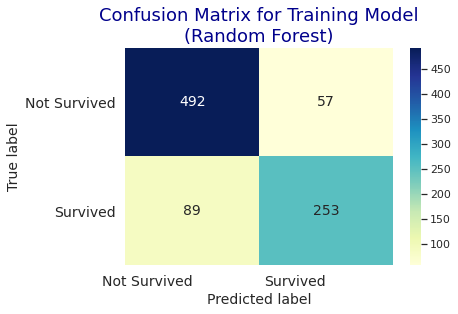

In [ ]:
# Plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={'size': 14}, fmt='d', cmap='YlGnBu')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix for Training Model\n(Random Forest)', fontsize=18, color='darkblue')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

In [ ]:
#create y_test prediction with the model
y_test_pred = random_forest.predict(X_test)
print(y_test_pred)

[0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0.
 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0.
 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0.
 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0.
 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1.
 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0.
 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0.
 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0.
 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1.
 1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1.
 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0.
 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0.

In [ ]:
df_test.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Family_Size,Family_Size_Grouped,Ticket_Frequency,Title,Is_Married,Pclass_1,Pclass_2,Pclass_3,Sex_1,Sex_2,Embarked_1,Embarked_2,Embarked_3,Title_1,Title_2,Title_3,Title_4,Family_Size_Grouped_1,Family_Size_Grouped_2,Family_Size_Grouped_3,Family_Size_Grouped_4
891,5,Unknown,1,2,"Kelly, Mr. James",0,892,3,1,0,NaN,330911,1,0,1,3,0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
892,7,Unknown,2,0,"Wilkes, Mrs. James (Ellen Needs)",0,893,3,0,1,NaN,363272,2,3,1,2,1,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
893,10,Unknown,1,4,"Myles, Mr. Thomas Francis",0,894,2,1,0,NaN,240276,1,0,1,3,0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
894,4,Unknown,2,4,"Wirz, Mr. Albert",0,895,3,1,0,NaN,315154,1,0,1,3,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
895,3,Unknown,2,5,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,896,3,0,1,NaN,3101298,3,3,2,2,1,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [ ]:

fill = pd.DataFrame(index =df_test.index[df_test.isnull().any(axis=1)], data= y_test_pred,columns=['Survived'])
df_test = df_test.fillna(fill)

In [ ]:
df_test.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Family_Size,Family_Size_Grouped,Ticket_Frequency,Title,Is_Married,Pclass_1,Pclass_2,Pclass_3,Sex_1,Sex_2,Embarked_1,Embarked_2,Embarked_3,Title_1,Title_2,Title_3,Title_4,Family_Size_Grouped_1,Family_Size_Grouped_2,Family_Size_Grouped_3,Family_Size_Grouped_4
891,5,Unknown,1,2,"Kelly, Mr. James",0,892,3,1,0,0.0,330911,1,0,1,3,0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
892,7,Unknown,2,0,"Wilkes, Mrs. James (Ellen Needs)",0,893,3,0,1,1.0,363272,2,3,1,2,1,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
893,10,Unknown,1,4,"Myles, Mr. Thomas Francis",0,894,2,1,0,0.0,240276,1,0,1,3,0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
894,4,Unknown,2,4,"Wirz, Mr. Albert",0,895,3,1,0,0.0,315154,1,0,1,3,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
895,3,Unknown,2,5,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,896,3,0,1,1.0,3101298,3,3,2,2,1,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 891 to 1308
Data columns (total 33 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Age                    418 non-null    int64  
 1   Cabin                  418 non-null    object 
 2   Embarked               418 non-null    int64  
 3   Fare                   418 non-null    int64  
 4   Name                   418 non-null    object 
 5   Parch                  418 non-null    int64  
 6   PassengerId            418 non-null    int64  
 7   Pclass                 418 non-null    int64  
 8   Sex                    418 non-null    int64  
 9   SibSp                  418 non-null    int64  
 10  Survived               418 non-null    float64
 11  Ticket                 418 non-null    object 
 12  Family_Size            418 non-null    int64  
 13  Family_Size_Grouped    418 non-null    int64  
 14  Ticket_Frequency       418 non-null    int64  
 15  Tit

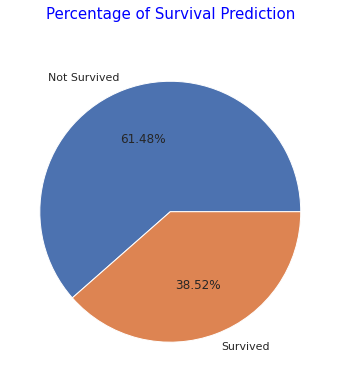

In [ ]:
import matplotlib.pyplot as plt
data = df_test.groupby('Survived')['PassengerId'].count().reset_index()
plt.figure(figsize=(6,6))
plt.pie(data['PassengerId'], labels = ['Not Survived','Survived'],autopct='%1.2f%%')
plt.title('Percentage of Survival Prediction',loc='center', pad=30, fontsize=15, color='blue')
plt.show()

In [ ]:
df_prediction = df_test[['PassengerId','Survived']].reset_index().drop(['index'], axis = 1).astype('int')
df_prediction.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [ ]:
#Convert to CSV File
df_prediction.to_csv('Predictions Result', index=False, sep=',')

In [ ]:
df_submission = pd.read_csv('gender_submission.csv')
df_submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
